### Data Ingestion, EDA & Visualization

* We will be using the AAVAIL datasets as a basis for this case study.
* We will include Data Ingestion, EDA & Visualization in this notebook. 

In [1]:
## import the following libraries
import os
import pandas as pd
import numpy as np
import sqlite3

## specify the directory you saved the data in
data_dir = os.path.join("..","data")

Let's make the connection to the database

In [2]:
## make a connection to the database
rdb_path = os.path.join(".","Data/aavail-customers.db")
conn = sqlite3.connect(rdb_path)

## print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


Now that we have extracted the relevant data from the DB, let's query the database and extract the following data into a Pandas DataFrame.

In [3]:
# write a query first
query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender
FROM CUSTOMER cu
INNER JOIN COUNTRY co
ON cu.country_id = co.country_id;
"""

_data = [d for d in conn.execute(query)]
columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender"]
df_db = pd.DataFrame(_data,columns=columns)

df_db.head()

customer_id    last_name first_name       DOB       city           state  \
0            1         Todd      Kasen  07/30/98  Rock Hill  South Carolina   
1            2        Garza     Ensley  04/12/89  singapore            None   
2            3        Carey    Lillian  09/12/97     Auburn         Alabama   
3            4  Christensen       Beau  01/28/99  Hempstead        New York   
4            5       Gibson    Ernesto  03/23/98  singapore            None   

         country gender  
0  united_states      m  
1      singapore      f  
2  united_states      f  
3  united_states      m  
4      singapore      m

Let's retrieve the data from csv files

In [4]:
df_streams = pd.read_csv(os.path.join(".",r"Data/aavail-streams.csv"))
print(df_streams.shape)
df_streams.head()

(18859, 5)


customer_id  stream_id        date  invoice_item_id  subscription_stopped
0            1     1420.0  2018-10-21              2.0                     0
1            1     1343.0  2018-10-23              2.0                     0
2            1     1756.0  2018-11-05              2.0                     0
3            1     1250.0  2018-11-06              2.0                     0
4            1     1324.0  2018-11-12              2.0                     0

Now we retrieve the data and form a small churned table

In [149]:
customer_ids = df_streams['customer_id'].values

#unique_ids = np.unique(df_streams['customer_id'].values)
unique_ids = df_streams.customer_id.unique()

streams = df_streams['subscription_stopped'].values
has_churned = [0 if streams[customer_ids==uid].max() > 0 else 1 for uid in unique_ids]
df_churn = pd.DataFrame({"customer_id": unique_ids,"is_subscriber": has_churned})

#df_churn.head(4)

#### Exploratory Data Analysis

**Implementation of checks for Quality Assurance**

- Remove any repeat customers based on customer_id
- Remove stream data that do not have an associated stream_id
- Check for missing values

In [7]:
print("\nCleaning Summary\n{}".format("-"*35))
duplicate_rows = df_db.duplicated()

if True in duplicate_rows:
    df_db = df_db[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

missing_stream_ids = np.isnan(df_streams['stream_id'])    
if True in missing_stream_ids:
    df_streams = df_streams[~missing_stream_ids]
    
    
print("Removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Removed 7 duplicate rows
Removed 1164 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id      0
last_name        0
first_name       0
DOB              0
city             0
state          300
country          0
gender           0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
invoice_item_id         0
subscription_stopped    0
dtype: int64


Now let's combine the data into a single data structure: We first use table-join method


In [11]:
## we form a new stream table
new_stream = df_streams[['customer_id','invoice_item_id','subscription_stopped']]\
            .groupby(['customer_id','invoice_item_id'],as_index=False).count()
new_stream.head(4)

customer_id  invoice_item_id  subscription_stopped
0            1              2.0                    23
1            2              3.0                    12
2            3              2.0                    22
3            4              1.0                    19

In [12]:
## retrieve data from "invoice item" table
invo_item = """
SELECT invoice_item_id, invoice_item as subscriber_type
FROM INVOICE_ITEM;
"""

_dat = [d for d in conn.execute(invo_item)]
columns = ["invoice_item_id","subscriber_type"]
sub_type = pd.DataFrame(_dat,columns=columns)

sub_type.head(3)

invoice_item_id   subscriber_type
0                1      aavail_basic
1                2    aavail_premium
2                3  aavail_unlimited

In order to meet our research goal, let's join the four tables together 

In [13]:
## now let's join the four tables together (form a dataset)

new_dat1 = pd.merge(df_churn,df_db,how="inner",left_on='customer_id',right_on='customer_id')
new_dat2 = pd.merge(new_dat1,new_stream,how="inner",left_on='customer_id',right_on='customer_id')
df_new = pd.merge(new_dat2,sub_type,how="inner",left_on="invoice_item_id",right_on="invoice_item_id")
# df_new.head()

## finalizing the dataset:
## convert age to days
df_new['age'] = np.datetime64('today') - pd.to_datetime(df_new['DOB'])
## convert to age(int) 
df_new['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_new['age'].values]

df_new['customer_name'] = df_new['first_name'] + " " + df_new['last_name']
df_new['num_streams'] = df_new['subscription_stopped']
new_col = ["country","state","customer_id","is_subscriber","customer_name","age","gender","subscriber_type","num_streams"]
dat = df_new[new_col]
dat = dat.sort_values(by=['customer_id'])

## reset index
dat = dat.reset_index()
dat.drop('index', inplace=True, axis=1)

## display
dat.head()

country           state  customer_id  is_subscriber  \
0  united_states  South Carolina            1              1   
1      singapore            None            2              0   
2  united_states         Alabama            3              0   
3  united_states        New York            4              1   
4      singapore            None            5              1   

      customer_name  age gender   subscriber_type  num_streams  
0        Kasen Todd   21      m    aavail_premium           23  
1      Ensley Garza   30      f  aavail_unlimited           12  
2     Lillian Carey   22      f    aavail_premium           22  
3  Beau Christensen   20      m      aavail_basic           19  
4    Ernesto Gibson   21      m    aavail_premium           23

In [ ]:
## ..To update target file..
import sys
import getopt
def update_target(target_file,df_clean,overwrite=False):
    """
    update line by line in case data are large
    """

    if overwrite or not os.path.exists(target_file):
        df_clean.to_csv(target_file,index=False)   
    else:
        df_target = pd.read_csv(target_file)
        df_target.to_csv(target_file, mode='a',index=False)
         
if __name__ == "__main__":
  
    ## collect args
    arg_string = "%s -d db_filepath -s streams_filepath"%sys.argv[0]
    try:
        optlist, args = getopt.getopt(sys.argv[1:],'d:s:')
    except getopt.GetoptError:
        print(getopt.GetoptError)
        raise Exception(arg_string)

    ## handle args
    streams_file = None
    db_file = None
    for o, a in optlist:
        if o == '-d':
            db_file = a
        if o == '-s':
            streams_file = a
    streams_file = os.path.join(DATA_DIR,streams_file)
    db_file = os.path.join(DATA_DIR,db_file)
    target_file = os.path.join(DATA_DIR,"Data/aavail-target.csv")
    
    ## make the connection to the database
    conn = connect_db(db_file)

    ## ingest data base data
    df_db = ingest_db_data(conn)
    df_streams, df_churn = ingest_stream_data(streams_file)
    df_clean = process_dataframes(df_db, df_streams, df_churn, conn)
    
    ## write
    update_target(target_file,df_clean,overwrite=False)
    print("done")


In [15]:
## Optional
## Another a method to obtain the expected dataset:
"""
import scipy.stats as stats

df_clean = df_churn.copy()
df_clean = df_clean[np.in1d(df_clean['customer_id'].values,df_db['customer_id'].values)]
unique_ids = df_clean['customer_id'].values

## ensure we are working with correctly ordered customer_ids df_db
if not np.array_equal(df_clean['customer_id'],df_db['customer_id']): 
    raise Exception("indexes are out of order or unmatched---needs to fix")

## query the db t create a invoice item map
query = """
#SELECT i.invoice_item_id, i.invoice_item FROM INVOICE_ITEM i;
"""

## variables for new df creation
invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}
streams_stopped = df_streams['subscription_stopped'].values
streams_cid = df_streams['customer_id'].values
streams_iid = df_streams['invoice_item_id'].values
subscriber_invoice_mode = [stats.mode(streams_iid[streams_cid==uid])[0][0] for uid in unique_ids]

## create the new df
df_clean['country'] = df_db['country']
df_clean['age'] = np.datetime64('today') - pd.to_datetime(df_db['DOB'])
df_clean['customer_name'] = df_db['first_name'] + " " + df_db['last_name']
df_clean['subscriber_type'] = [invoice_item_map[int(sim)] for sim in subscriber_invoice_mode]
df_clean['num_streams'] = [streams_stopped[streams_cid==uid].size for uid in unique_ids]

## convert age to days
df_clean['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_clean['age'].values]
"""

#### Data Visualization

In [14]:
#import Data Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
print(pd.crosstab(dat.is_subscriber, dat.country))

country        singapore  united_states
is_subscriber                          
0                    181            108
1                    119            592


In [53]:
## mean of "num_streams"
_plotting = dat[['is_subscriber','num_streams']]\
           .groupby(['is_subscriber']).mean()
print(_plotting)

               num_streams
is_subscriber             
0                16.747405
1                18.080169


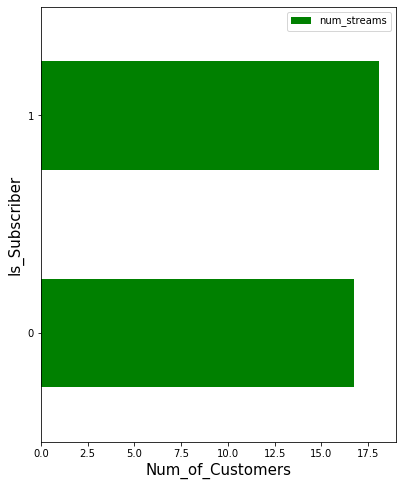

In [55]:
## first plot
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)

table_c = pd.pivot_table(dat, index = ['is_subscriber'], values = 'num_streams')
table_c.plot(kind='barh',ax=ax1,color='g')
ax1.set_ylabel("Is_Subscriber",size=15);
ax1.set_xlabel("Num_of_Customers",size=15);

In [49]:
_plotting = dat[['country', 'subscriber_type', 'is_subscriber']]\
           .groupby(['country', 'subscriber_type']).mean()
print(_plotting)

                                is_subscriber
country       subscriber_type                
singapore     aavail_basic           0.600000
              aavail_premium         0.309524
              aavail_unlimited       0.218750
united_states aavail_basic           0.858300
              aavail_premium         0.838057
              aavail_unlimited       0.839806


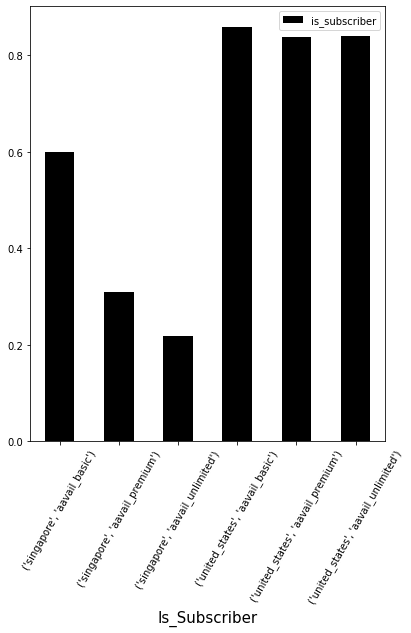

In [45]:
## 2nd plot
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)

table1 = pd.pivot_table(dat, index = ['country', 'subscriber_type'], values = 'is_subscriber')
table1.plot(kind='bar',ax=ax1,color='black')
ax1.set_xlabel("Is_Subscriber",size=15)
ax1.set_xticklabels(table1.index, rotation=60);

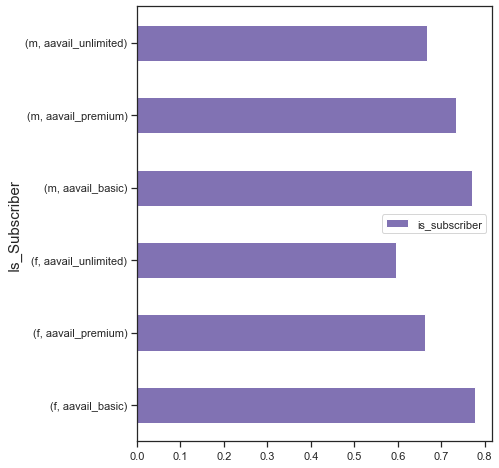

In [146]:
## 3rd plot
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)

table1 = pd.pivot_table(dat, index = ['gender', 'subscriber_type'], values = 'is_subscriber')
table1.plot(kind='barh',ax=ax1, color='m')
ax1.set_ylabel("Is_Subscriber",size=15);

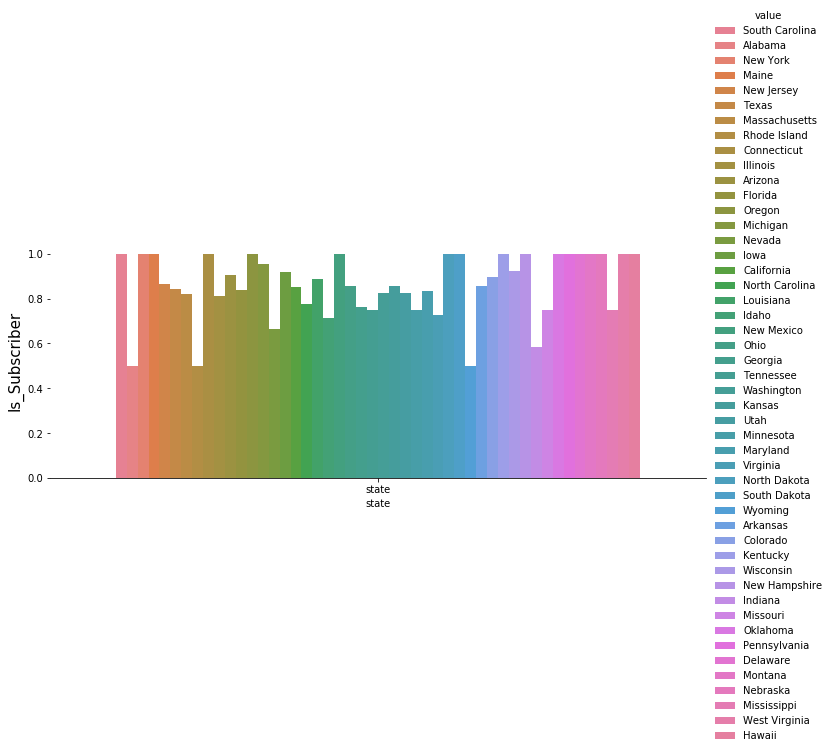

In [91]:
## 4th plot
# Create a new temporary dataframe to help us plot these variables.
df1 = pd.melt(dat, id_vars=['is_subscriber'], value_vars=["state"], var_name='state')

# Create a factorplot
g = sns.factorplot( x="state", y="is_subscriber", hue='value', data=df1, size=4,
                   aspect=2.5, kind="bar", palette="husl", ci=None)
g.despine(left=True)
g.set_ylabels("Is_Subscriber",size=15)
plt.show()

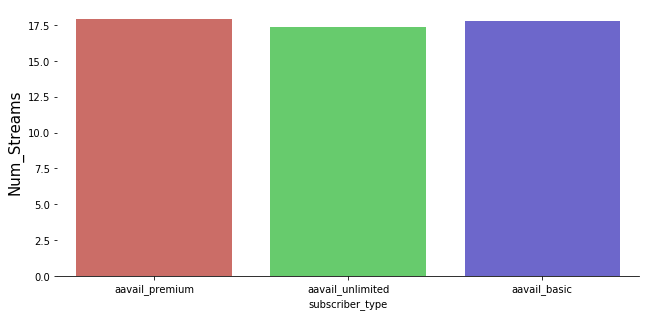

In [96]:
## 5th plot
## Create a factorplot
j = sns.factorplot( x="subscriber_type", y="num_streams", 
                   data=dat, size=4.5, aspect=2, kind="bar", palette= "hls", ci=None )
j.despine(left=True)
j.set_ylabels("Num_Streams",size=15)
plt.show()

The above analysis explains the num_streams distribution among subscribers and non-subscribers, however this information is not enough and we will need to create an age distribution for different countries. Let's analyze num_streams distribution for different countries.

In [97]:
## pivot table
dat.pivot_table('age', index='country', columns='is_subscriber')

is_subscriber          0          1
country                            
singapore      24.729282  23.815126
united_states  23.175926  25.798986

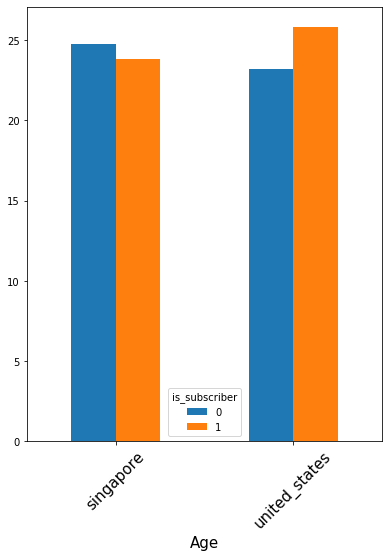

In [101]:
## 6th plot
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)

table3 = dat.pivot_table('age', index='country', columns='is_subscriber')
table3.plot(kind='bar',ax=ax1)
ax1.set_xlabel("Age",size=15)
ax1.set_xticklabels(table3.index, rotation=45, size=15);

The analysis above shows that the average age of both subscribers and non-subscribers is almost 25 years of age in Singapore. This gives us an important insight to analyze the avergae age for each subscriber_type.

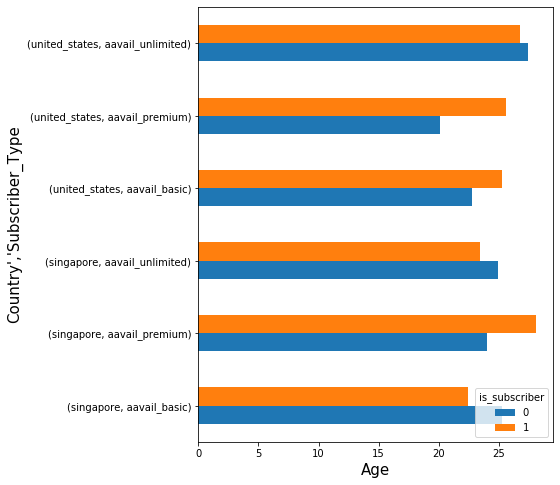

In [104]:
## 7th plot
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)

table4 = dat.pivot_table('age', index=['country','subscriber_type'], columns='is_subscriber')
table4.plot(kind='barh',ax=ax1)
ax1.set_xlabel("Age",size=15)
ax1.set_ylabel("Country','Subscriber_Type",size=15);

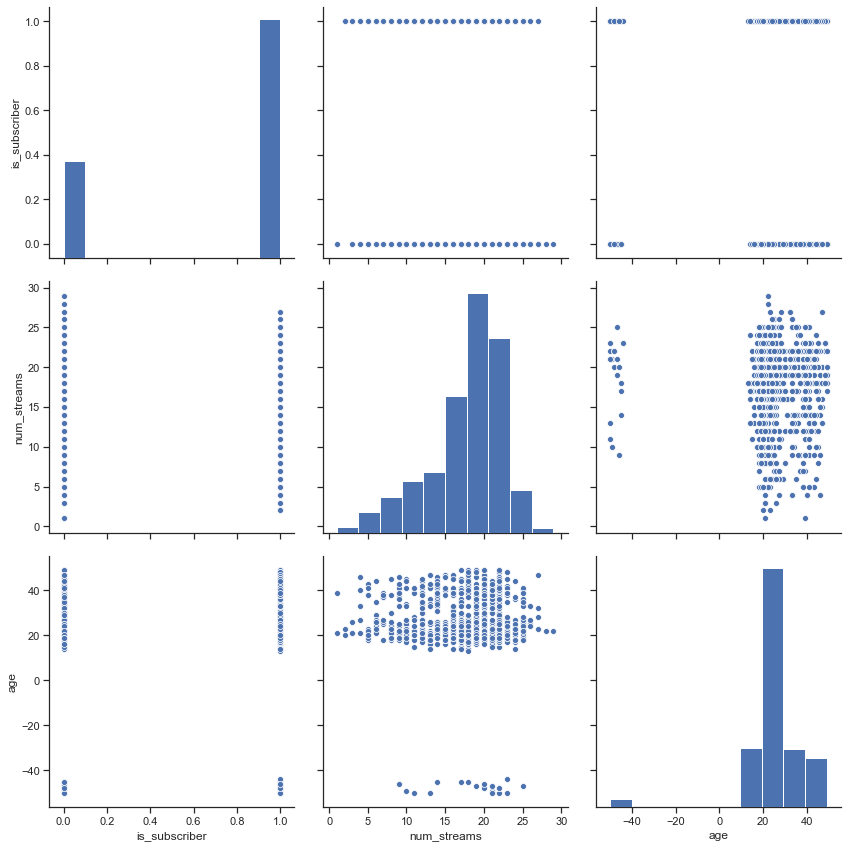

In [148]:
## 8th plot
import seaborn as sns
sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = ['is_subscriber', 'num_streams', 'age']

axes = sns.pairplot(dat, vars=columns, palette="husl", size=4)


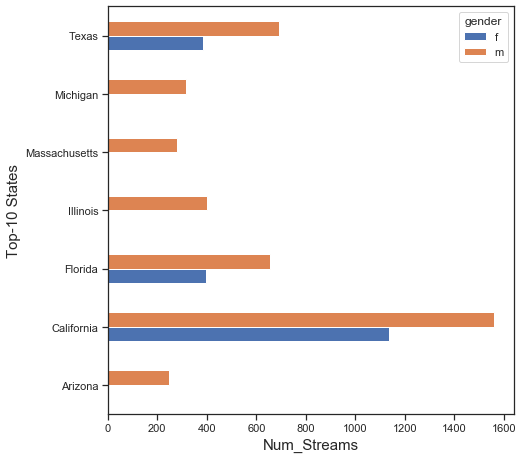

In [144]:
## plot Top-10 state based on "Num_Streams" divided by gender

dat1 = dat[dat['state']!=None]
dat2 = dat1[['state','gender','num_streams']].groupby(['state','gender']).sum()
dat2 = dat2.reset_index()
dat3 = dat2.sort_values('num_streams',ascending=False)

dat3 = dat3.head(10)

fig = plt.figure(figsize=(16,7.5))
ax1 = fig.add_subplot(121)

table2 = dat3.pivot_table('num_streams', index='state', columns='gender')
table2.plot(kind='barh',ax=ax1)
ax1.set_xlabel("Num_Streams",size=15)
ax1.set_ylabel("Top-10 States",size=15);


**As we undertsand that the goal of our data analysis was to find factors that are influencing the business market**
    